In [1]:
import numpy as np

from scipy.linalg import subspace_angles

import matplotlib.pyplot as plt

from cca import synth_data

from cca import ComplexityComponentsAnalysis as CCA
from cca.cca import ortho_reg_fn
from cca import methods_comparison as mc

import torch
import torch.nn.functional as F

In [2]:
from numpy.fft import rfft, rfftfreq

In [3]:
channels = 40
T = 10000
T_ent = 10
d = 2

In [4]:
cov = np.diag(np.ones(channels)) * .002
X = synth_data.embed_lorenz_system(T, .005, .005, channels, cov)
X = X[1000:]

In [5]:
fca = mc.ForcastableComponentsAnalysis(d, T_ent, verbose=True)

In [6]:
fca.fit(X)

tensor([0.1314, 0.4668], dtype=torch.float64, grad_fn=<NegBackward>)
Ent: 0.2991 bits, reg: 0.0
tensor([0.1314, 0.4668], dtype=torch.float64, grad_fn=<NegBackward>)
tensor([0.0798, 0.0465], dtype=torch.float64, grad_fn=<NegBackward>)
tensor([0.1135, 0.0874], dtype=torch.float64, grad_fn=<NegBackward>)
tensor([0.1135, 0.0874], dtype=torch.float64, grad_fn=<NegBackward>)
Ent: 0.1004 bits, reg: 0.0305
tensor([0.1045, 0.0738], dtype=torch.float64, grad_fn=<NegBackward>)
tensor([0.1102, 0.0822], dtype=torch.float64, grad_fn=<NegBackward>)
tensor([0.1102, 0.0822], dtype=torch.float64, grad_fn=<NegBackward>)
Ent: 0.0962 bits, reg: 0.0001
tensor([0.1075, 0.0791], dtype=torch.float64, grad_fn=<NegBackward>)
tensor([0.0982, 0.0694], dtype=torch.float64, grad_fn=<NegBackward>)
tensor([0.0982, 0.0694], dtype=torch.float64, grad_fn=<NegBackward>)
Ent: 0.0838 bits, reg: 0.0003
tensor([0.0812, 0.0572], dtype=torch.float64, grad_fn=<NegBackward>)
tensor([0.0812, 0.0572], dtype=torch.float64, grad_fn=<

tensor([0.0375, 0.0390], dtype=torch.float64, grad_fn=<NegBackward>)
Ent: 0.0383 bits, reg: 0.0
tensor([0.0372, 0.0388], dtype=torch.float64, grad_fn=<NegBackward>)
tensor([0.0372, 0.0388], dtype=torch.float64, grad_fn=<NegBackward>)
Ent: 0.038 bits, reg: 0.0
tensor([0.0361, 0.0385], dtype=torch.float64, grad_fn=<NegBackward>)
tensor([0.0370, 0.0386], dtype=torch.float64, grad_fn=<NegBackward>)
tensor([0.0370, 0.0386], dtype=torch.float64, grad_fn=<NegBackward>)
Ent: 0.0378 bits, reg: 0.0001
tensor([0.0368, 0.0385], dtype=torch.float64, grad_fn=<NegBackward>)
tensor([0.0368, 0.0385], dtype=torch.float64, grad_fn=<NegBackward>)
Ent: 0.0377 bits, reg: 0.0001
tensor([0.0367, 0.0384], dtype=torch.float64, grad_fn=<NegBackward>)
tensor([0.0367, 0.0384], dtype=torch.float64, grad_fn=<NegBackward>)
Ent: 0.0375 bits, reg: 0.0
tensor([0.0363, 0.0383], dtype=torch.float64, grad_fn=<NegBackward>)
tensor([0.0365, 0.0383], dtype=torch.float64, grad_fn=<NegBackward>)
tensor([0.0365, 0.0383], dtype=t

tensor([0.0356, 0.0349], dtype=torch.float64, grad_fn=<NegBackward>)
Ent: 0.0353 bits, reg: 0.0
tensor([0.0356, 0.0349], dtype=torch.float64, grad_fn=<NegBackward>)
tensor([0.0356, 0.0349], dtype=torch.float64, grad_fn=<NegBackward>)
Ent: 0.0353 bits, reg: 0.0
tensor([0.0352, 0.0351], dtype=torch.float64, grad_fn=<NegBackward>)
tensor([0.0355, 0.0350], dtype=torch.float64, grad_fn=<NegBackward>)
tensor([0.0355, 0.0350], dtype=torch.float64, grad_fn=<NegBackward>)
Ent: 0.0352 bits, reg: 0.0
tensor([0.0353, 0.0351], dtype=torch.float64, grad_fn=<NegBackward>)
tensor([0.0353, 0.0351], dtype=torch.float64, grad_fn=<NegBackward>)
Ent: 0.0352 bits, reg: 0.0
tensor([0.0353, 0.0351], dtype=torch.float64, grad_fn=<NegBackward>)
tensor([0.0353, 0.0351], dtype=torch.float64, grad_fn=<NegBackward>)
Ent: 0.0352 bits, reg: 0.0
tensor([0.0353, 0.0351], dtype=torch.float64, grad_fn=<NegBackward>)
tensor([0.0353, 0.0351], dtype=torch.float64, grad_fn=<NegBackward>)
Ent: 0.0352 bits, reg: 0.0
tensor([0.

In [8]:
r = np.squeeze(fca.transform(X))

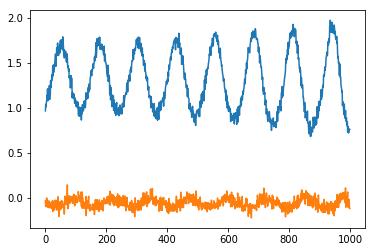

In [75]:
plt.plot(r[:1000])

In [76]:
model = CCA(d, 5)

In [77]:
rc = np.squeeze(model.fit_transform(X))

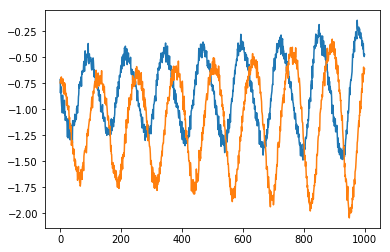

In [78]:
plt.plot(rc[:1000])

In [79]:
subspace_angles(fca.coef_, model.coef_)

array([1.55338689, 1.11815238])